<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Text-Preprocessing" data-toc-modified-id="Text-Preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Text Preprocessing</a></span><ul class="toc-item"><li><span><a href="#Load-Datasets-and-Quick-Examination" data-toc-modified-id="Load-Datasets-and-Quick-Examination-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Load Datasets and Quick Examination</a></span></li><li><span><a href="#Check-Missing-Values" data-toc-modified-id="Check-Missing-Values-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Check Missing Values</a></span></li><li><span><a href="#Further-Examine-the-Data-and-Create-a-Data-Cleaning-Strategy" data-toc-modified-id="Further-Examine-the-Data-and-Create-a-Data-Cleaning-Strategy-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Further Examine the Data and Create a Data Cleaning Strategy</a></span></li></ul></li><li><span><a href="#Exploratory-Data-Analysis" data-toc-modified-id="Exploratory-Data-Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Exploratory Data Analysis</a></span></li><li><span><a href="#Text-Feature-Extraction" data-toc-modified-id="Text-Feature-Extraction-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Text Feature Extraction</a></span></li><li><span><a href="#Modelling" data-toc-modified-id="Modelling-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Modelling</a></span><ul class="toc-item"><li><span><a href="#Split-into-train/test-dataset" data-toc-modified-id="Split-into-train/test-dataset-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Split into train/test dataset</a></span></li><li><span><a href="#Build-Multi-Label-Classifier" data-toc-modified-id="Build-Multi-Label-Classifier-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Build Multi-Label Classifier</a></span></li></ul></li></ul></div>

# Text Preprocessing

In [1]:
# necessary libraries
import pandas as pd
import numpy as np
import re

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# for NLP tasks
import spacy
nlp = spacy.load("en_core_web_sm")
import nltk

# for feature extraction
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# for model building
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

## Load Datasets and Quick Examination

In [2]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
# Ratio between training set and test set
print ("training percentage %.2f" % (df.shape[0]/(df.shape[0]+test.shape[0])))
print ("test percentage %.2f" % (test.shape[0]/(df.shape[0]+test.shape[0])))

training percentage 0.51
test percentage 0.49


**labeled vs. nonlabeled**
- For training dataset, each row represents a comment with a unique id and 6 binary labels: toxic, sever toxic, obscene, threat, insult, identity hate.
- Each comment can have multiple labels or no label at all, depending on whether it contains toxic messages.

In [4]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


**imbalanced dataset**
- The dataset is imbalanced with 90% nonlabeled and 10% labeled. 

In [5]:
# Create a new category indicating non-labeled data
# 1 being qualified, 0 being non-qualified
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
df['nontoxic'] = 1- df[label_cols].max(axis=1)
df['nontoxic'].value_counts(normalize=True)

1    0.898321
0    0.101679
Name: nontoxic, dtype: float64

## Check Missing Values

**no missing value observed**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 9 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
nontoxic         159571 non-null int64
dtypes: int64(7), object(2)
memory usage: 11.0+ MB


## Further Examine the Data and Create a Data Cleaning Strategy

**Examination on non-toxic examples**

In [7]:
print (df['nontoxic'][1])
df['comment_text'][1]

1


"D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)"

In [8]:
print (df['nontoxic'][3])
df['comment_text'][3]

1


'"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It\'s listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "'

In [9]:
print (df['nontoxic'][5])
df['comment_text'][5]

1


'"\n\nCongratulations from me as well, use the tools well. \xa0· talk "'

In [10]:
print (df['nontoxic'].iloc[-1])
df['comment_text'].iloc[-1]

1


'"\nAnd ... I really don\'t think you understand.  I came here and my idea was bad right away.  What kind of community goes ""you have bad ideas"" go away, instead of helping rewrite them.   "'

**Examination on toxic examples**

In [11]:
toxic = df.loc[df['nontoxic'] == 0]

In [12]:
toxic = toxic.reset_index(drop=True)

In [13]:
print (toxic.iloc[1, 1])

Hey... what is it..
@ | talk .
What is it... an exclusive group of some WP TALIBANS...who are good at destroying, self-appointed purist who GANG UP any one who asks them questions abt their ANTI-SOCIAL and DESTRUCTIVE (non)-contribution at WP?

Ask Sityush to clean up his behavior than issue me nonsensical warnings...


In [14]:
print (toxic.iloc[5, 1])

I'm Sorry 

I'm sorry I screwed around with someones talk page.  It was very bad to do.  I know how having the templates on their talk page helps you assert your dominance over them.  I know I should bow down to the almighty administrators.  But then again, I'm going to go play outside....with your mom.   76.122.79.82


In [15]:
print (toxic.iloc[-2, 1])

"

Hey listen don't you ever!!!! Delete my edits ever again I'm annoyed because the WWE 2K15 a few of the roster have been confirmed and your stupid ass deletes what I write. just stop!!!! Please STOP!!!! You don't work 2k or WWE games so stop deleting other peoples shit if I get it wrong or others get it wrong let them they will get the hang of it eventually but don't stick your most ass in their and I'm gonna delete the ""please do not insert the roster"" shit how do you not have it if has been confirmed!!!!! God your stupid."


### Context Review:
**What data cleaning task should be applied for this dataset?**
- There are no obvious spelling mistakes observed.
- There are HTML tags and newline characters.
- Contractions, shortened version of words and phrases, are commonly used, since we're dealing with online comments.

**Any extra information?**
- For some comments, the userID and post time of commenter are shown.

**What issues appeared frequently?**
- Complains about comments or edits being erased
- Topics related to WWII, religious etc.

**Any interesting user behaviors?**
- Toxic keywords are often typed in UPPER CASE with special characters to enhance commenters' anger.
- Toxic keywords are often used as Nouns or Verbs.


In [16]:
# Remove HTML tags
from bs4 import BeautifulSoup
def remove_html(text):
    return BeautifulSoup(text, "html.parser").text

In [17]:
# Expand contractions
# Leverage the contractions module, contributed by Dipanjan Sarkar
from contractions import CONTRACTION_MAP
CONTRACTION_MAP

{"ain't": 'is not',
 "aren't": 'are not',
 "can't": 'cannot',
 "can't've": 'cannot have',
 "'cause": 'because',
 "could've": 'could have',
 "couldn't": 'could not',
 "couldn't've": 'could not have',
 "didn't": 'did not',
 "doesn't": 'does not',
 "don't": 'do not',
 "hadn't": 'had not',
 "hadn't've": 'had not have',
 "hasn't": 'has not',
 "haven't": 'have not',
 "he'd": 'he would',
 "he'd've": 'he would have',
 "he'll": 'he will',
 "he'll've": 'he he will have',
 "he's": 'he is',
 "how'd": 'how did',
 "how'd'y": 'how do you',
 "how'll": 'how will',
 "how's": 'how is',
 "I'd": 'I would',
 "I'd've": 'I would have',
 "I'll": 'I will',
 "I'll've": 'I will have',
 "I'm": 'I am',
 "I've": 'I have',
 "i'd": 'i would',
 "i'd've": 'i would have',
 "i'll": 'i will',
 "i'll've": 'i will have',
 "i'm": 'i am',
 "i've": 'i have',
 "isn't": 'is not',
 "it'd": 'it would',
 "it'd've": 'it would have',
 "it'll": 'it will',
 "it'll've": 'it will have',
 "it's": 'it is',
 "let's": 'let us',
 "ma'am": 'mad

In [18]:
# Expand contractions
# Leverage the contractions module, contributed by Dipanjan Sarkar
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [19]:
# remove new line characters
def remove_newline(text):
    return text.replace('\n',' ')

In [20]:
# remove special characters, such as escape characters and punctuations
def remove_special_chars(text, remove_digit = False):
    if remove_digit:
        return  re.sub(r"[^a-zA-Z ]"," ",text)
    else:
        return re.sub(r"[^\w\s]"," ",text)

In [21]:
# remove extra whitespaces
def remove_extra_spaces(text):
    return " ".join(text.split())

In [22]:
# clean text function
def clean_corpus(corpus, html_stripping = True, contractions_fix = True, 
                newline_removal = True, special_chars_removal= True,
                extra_spaces_removal = True):
    # remove HTML tags
    if html_stripping:
        doc = remove_html(corpus)
    # expand contractions
    if contractions_fix:
        doc = expand_contractions(doc)
    # remove new line
    if newline_removal:
        doc = remove_newline(doc)
    # remove special characters
    if special_chars_removal:
        doc = remove_special_chars(doc, remove_digit = False)
    # remove extra white spaces
    if extra_spaces_removal:
        doc = remove_extra_spaces(doc)
    return doc

In [23]:
df['clean_comment'] = df['comment_text'].apply(clean_corpus)

/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:335: UserWarning: "http://en.wikipedia.org/wiki/Wikipedia_talk:No_original_research/archive15#YouTube_art_as_primary_source" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:335: UserWarning: "http://finance.yahoo.com/news/7-fascinating-nuggets-another-bewildering-150348488.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:335: UserWarning: "http://en.wikipedia.org/wiki/Wikipedia:ELYES" looks like a URL. Beautiful Soup is not an HTTP client

In [24]:
# calculate how many words are all capitals
def all_caps(text):
    return (sum(1 for t in text.split() if t.isupper()))
df['num_allcaps'] = df['comment_text'].apply(all_caps)

In [25]:
# lemmatize words
def lemmatizer(text):
    doc = nlp(text)
    lemma_list = []
    for token in doc:
        if token.lemma_ == "-PRON-":
            lemma_list.append(token.text)
        else: 
            lemma_list.append(token.lemma_)
    return ' '.join(lemma_list)

In [26]:
# remove stopwords
from nltk import word_tokenize
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english')) 
def remove_stopword(text):
    result = [t for t in word_tokenize(text.lower()) if t not in stopwords]
    return ' '.join(result)

In [27]:
# normalize the corpus 
def normalize_corpus(corpus, stopword_removal = True):
    if stopword_removal:
        doc = remove_stopword(corpus)
    return doc

In [28]:
df['clean_comment'] = df['clean_comment'].apply(normalize_corpus)

In [29]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,nontoxic,clean_comment,num_allcaps
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1,explanation edits made username hardcore metal...,2
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,daww matches background colour seemingly stuck...,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1,hey man really trying edit war guy constantly ...,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,make real suggestions improvement wondered sec...,5
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,sir hero chance remember page,0


# Exploratory Data Analysis

In [30]:
sns.set_style("dark")

**How many data is distributed to each class?**

The data is imbalanced with 90% comments belonging to non-toxic class. "toxic" is the top class for hate speech comments, with threat-related comments being observed the less.

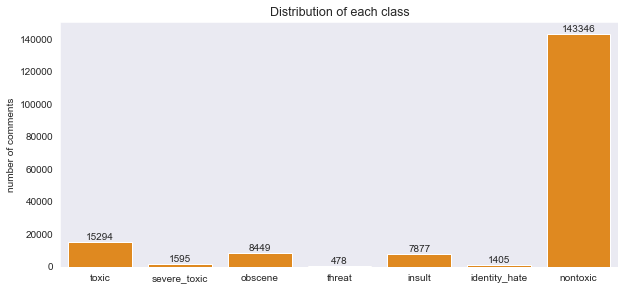

In [31]:
# bar plot
colors = ['darkorange']
plt.figure(figsize = (10,4.5))
class_data = df.iloc[:, 2:9]
ax = sns.barplot(list(class_data.columns), class_data.sum(), palette = colors)
plt.title("Distribution of each class", fontsize = 12.5)
plt.ylabel("number of comments")
rects = ax.patches
total = class_data.sum()
for rect, total in zip(rects, total):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, total, ha='center', va='bottom')

**What words are most mentioned in each class?**

In [32]:
# prepare comment of each class for creating wordcloud image
toxic = " ".join(comment for comment in df.loc[df['toxic'] == 1, 'clean_comment'])
severe_toxic =  " ".join(comment for comment in df.loc[df['severe_toxic'] == 1, 'clean_comment'])
obscene = " ".join(comment for comment in df.loc[df['obscene'] == 1, 'clean_comment'])
threat = " ".join(comment for comment in df.loc[df['threat'] == 1, 'clean_comment'])
insult = " ".join(comment for comment in df.loc[df['insult'] == 1, 'clean_comment'])
identity_hate = " ".join(comment for comment in df.loc[df['identity_hate'] == 1, 'clean_comment'])

In [33]:
toxic_wordcloud = WordCloud(max_font_size= 200, max_words = 100, background_color="white", collocations=False).generate(toxic)
severe_toxic_wordcloud = WordCloud(max_font_size= 200, max_words = 100, background_color="white", collocations=False).generate(severe_toxic)
obscene_wordcloud = WordCloud(max_font_size= 200, max_words = 100, background_color="white", collocations=False).generate(obscene)
threat_wordcloud = WordCloud(max_font_size= 200, max_words = 100, background_color="white", collocations=False).generate(threat)
insult_wordcloud = WordCloud(max_font_size= 200, max_words = 100, background_color="white", collocations=False).generate(insult)
identity_hate_wordcloud = WordCloud(max_font_size= 200, max_words = 100, background_color="white", collocations=False).generate(identity_hate)

(<matplotlib.axes._subplots.AxesSubplot at 0x1a33d89b70>,
 (-0.5, 399.5, 199.5, -0.5),
 Text(0.5, 1.0, 'identity_hate'))

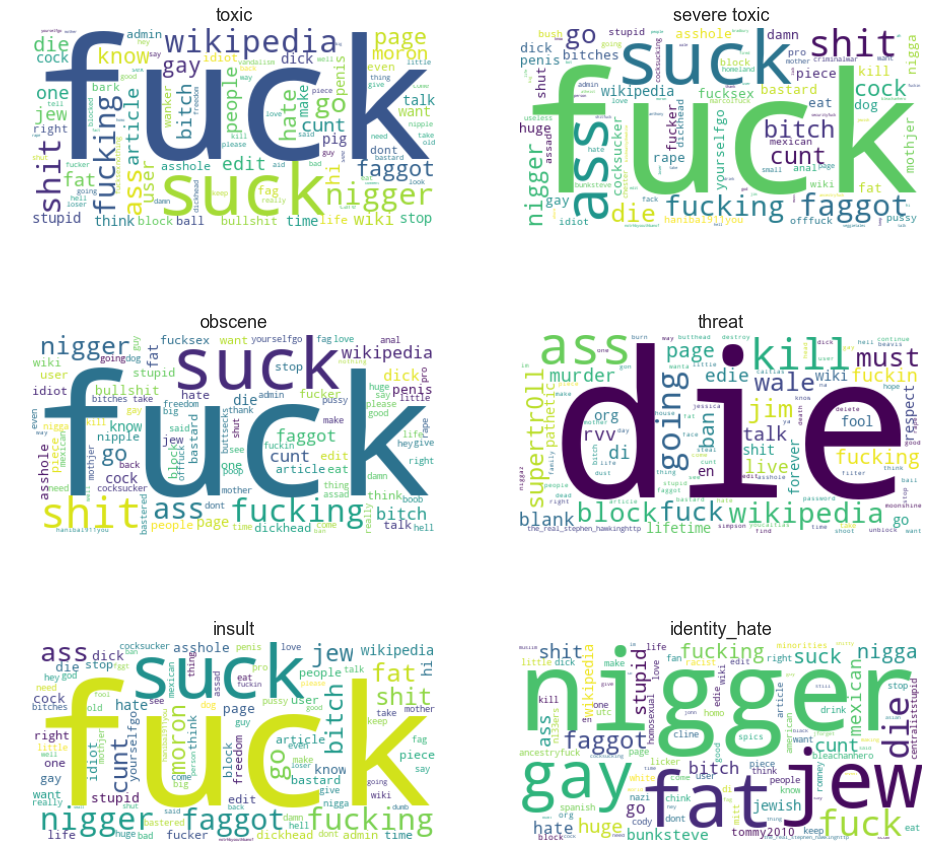

In [34]:
# plot wordcloud image for 6 class
fig=plt.figure(figsize=(16, 16))
plt.subplot(3,2,1), plt.imshow(toxic_wordcloud,interpolation="bilinear"), plt.axis("off"), plt.title('toxic', fontsize=18)
plt.subplot(3,2,2), plt.imshow(severe_toxic_wordcloud,interpolation="bilinear"), plt.axis("off"), plt.title('severe toxic', fontsize=18)
plt.subplot(3,2,3), plt.imshow(obscene_wordcloud,interpolation="bilinear"), plt.axis("off"), plt.title('obscene', fontsize=18)
plt.subplot(3,2,4), plt.imshow(threat_wordcloud,interpolation="bilinear"), plt.axis("off"), plt.title('threat', fontsize=18)
plt.subplot(3,2,5), plt.imshow(insult_wordcloud,interpolation="bilinear"), plt.axis("off"), plt.title('insult', fontsize=18)
plt.subplot(3,2,6), plt.imshow(identity_hate_wordcloud,interpolation="bilinear"), plt.axis("off"), plt.title('identity_hate', fontsize=18)

**How to separate the 6 groups based on dictionary definition**
- toxic: "Very harmful or unpleasant in a pervasive or insidious way", "extremely harsh, malicious, or harmful"
- obscene: "containing or being language regarded as taboo in polite usage", "connected with sex in a way that most people find offensive", "(of the portrayal or description of sexual matters) offensive or disgusting by accepted standards of morality and decency"
- threat: "an expression of intention to inflict evil, injury, or damage", "a statement in which you tell somebody that you will punish or harm them, especially if they do not do what you want"
- insult:"to affect offensively or damagingly", "A disrespectful or scornfully abusive remark or act"
- identity hate: "abusive or threatening speech or writing that expresses prejudice against a particular group, especially on the basis of race, religion, or sexual orientation"


**Initial Findings From WordCloud**
- Since it is a multi-class dataset, which means that, one comment might get more than one labels, keywords such as "fuck" and "suck" are commonly seen across different groups.
- Though the keywords seem to be similar among groups at first glance, "obscene" class is highly associated with sex-related words, "threat" is related to physical-abuse words, "identity hate" is associated with race and gender identity.

# Text Feature Extraction
- Text content has to be converted into numerical feature vectors before feeding to machine learning algorithms, which only accept numerical input.
- `Bag-of-Words` and `TF-IDF` are common text representation that treat each the occurence frequency of individual token as feature.

**Limitation** : `Bag-of-Words` and `TF-IDF` ignore the semantic relationship between words because they don't consider the oder.

### Bag-of-Word Representation
- Bag-of-Word (BOW) counts how many times a word appears in a document. It transforms the corpus of documents into a big matrix of token counts. Each row is per document and each column is the occurence frequency per token.
- Words that don't appear in the corpus will not be represented.

In [35]:
# use BOW to tokenize and count the word occurences of a mini corpus
mini_corpus = df['clean_comment'].sample(n = 1, random_state = 0)
print (mini_corpus)
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(mini_corpus)
# BOW matrix
X.toarray()

74251    paraphrased gary complained preferring recent ...
Name: clean_comment, dtype: object


array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1]], dtype=int64)

### TF-IDF Term Weighting¶
- TF-IDF (Term Frequency - Inverse Document Frequency) add weights to words according to their relevant importance. The purpose is to highlight the weights of unique words, which should be more representative than repetitive words such as "the" and "a" ect.
- TF calculates the occurence frequency of a word in a single document, and IDF measures how often the word appears in all documents. 

# Modelling

### Define Problem
**Multi-label classification problem instead of Multi-class problem** 
- Multi-label classification:  Each comment can be assigned to more than one labels. It is expressed with label binary indicator array.
- Multi-class classification: There are more than two kinds of labels but each sample can only have one and only one label. 

### Decide Metrics
**Evaluation Metric**
The Kaggle Competition requires to use ROC AUC to evaluate the model performance, which is particularly good at binary classification problem. 
ROC Curve is a common way to visualize the trade off of TPR and FPR when applying different threshold. It is incensitive to unbalanced dataset and can also help to find the optimal threshold. AUC can provide a single value to help us quickly compare the differnece performance of each classification model.

**Other possible metrics to consider** 
(open to edit)

### Decide Solutions
- Models that are good at handling classification problems such as logitic regression, naive bayes, and SVM etc will be used.
- The baseline model is logistic regression with bigram starting from raw text data.

## Split into train/test dataset

In [36]:
# split the data into training and test
train, test = train_test_split(df, random_state = 0, test_size=0.2, shuffle=True)

In [37]:
X_train = train['clean_comment']
X_test = test['clean_comment']

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

## Build Multi-Label Classifier

### Baseline Model: 
Here, I use Logistic Regression with bigrams and tfidf extracting text features as baseline models.

In [38]:
# apply sklearn pipeline to build logistic regression model 
# vectorize text using bag-of-bigrams representation
# use OneVsRest strategy

LogReg_pipeline = Pipeline([('bow', CountVectorizer(ngram_range = (1, 2))), 
                            ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
auc = []
for label in labels:
    print('... Processing {}'.format(label))
    # train the model using X_train & y
    LogReg_pipeline.fit(X_train, train[label])
    # compute the testing accuracy
    pred_y_test = LogReg_pipeline.predict(X_test)
    print('ROC_AUC score is {}'.format(roc_auc_score(test[label], pred_y_test)))
    auc.append(roc_auc_score(test[label], pred_y_test))
print('mean column-wise ROC AUC:', np.mean(auc))

... Processing toxic


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


ROC_AUC score is 0.5876839996376587
... Processing severe_toxic


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


ROC_AUC score is 0.5316616168488328
... Processing obscene


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


ROC_AUC score is 0.6067911775027537
... Processing threat


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


ROC_AUC score is 0.5054787940817352
... Processing insult


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


ROC_AUC score is 0.5665660576954152
... Processing identity_hate


/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


ROC_AUC score is 0.5066955951188438
mean column-wise ROC AUC: 0.5508128734808732


In [39]:
# TF-IDF
LogReg_pipeline_tfidf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
auc = []
for label in labels:
    print('... Processing {}'.format(label))
    # train the model using X_train & y
    LogReg_pipeline_tfidf.fit(X_train, train[label])
    # compute the testing accuracy
    pred_y_test = LogReg_pipeline_tfidf.predict(X_test)
    print('ROC_AUC score is {}'.format(roc_auc_score(test[label], pred_y_test)))
    auc.append(roc_auc_score(test[label], pred_y_test))
print('mean column-wise ROC AUC:', np.mean(auc))

... Processing toxic
ROC_AUC score is 0.7904191663342557
... Processing severe_toxic
ROC_AUC score is 0.611496388400309
... Processing obscene
ROC_AUC score is 0.8071256700599858
... Processing threat
ROC_AUC score is 0.5493405695611578
... Processing insult
ROC_AUC score is 0.7479562988031411
... Processing identity_hate
ROC_AUC score is 0.5951631555787357
mean column-wise ROC AUC: 0.6835835414562642


- Since Tfidf shows the higher score, I choose to use tfidf as the text feature extraction method. Before trying out other models and fine tuning their parameters, I use GridsearchCV to automatically select the best hyperparameter for tfidf and apply it to other models.

### Tfidf Hyperparameter Tuning:

In [40]:
from sklearn.model_selection import GridSearchCV

# hyper-parameter tuning 
# define a pipeline with tfidf as text feature extractor with the baseline model, logistic regression
pipe = Pipeline([('tfidf', TfidfVectorizer()), 
                 ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])

parameters = {'tfidf__ngram_range' : [(1,1), (1,2)], # unigrams or bigrams
              'tfidf__max_df' : [0.5, 0.75, 1.0], # ignore terms that have a document frequency higher than threshold 
              'tfidf__max_features' : [10000, 30000, 50000], # limit the amoung of features(vocabularly) that the vectorizer will learb
             } 

In [47]:
grid_search = GridSearchCV(pipe, param_grid = parameters, cv = 3, scoring = 'roc_auc')
grid_search.fit(X_train, train[label])
print ('Best score: %0.3f' % grid_search.best_score_)
print ('Best paramters set:', grid_search.best_params_)

Best score: 0.976
Best paramters set: {'tfidf__max_df': 1.0, 'tfidf__max_features': 30000, 'tfidf__ngram_range': (1, 2)}


In [48]:
tfidf = TfidfVectorizer(max_df = 0.5, max_features = 30000, ngram_range = (1, 1))

**Naive Bayes**

In [49]:
# TF-IDF

NB_pipeline_tfidf = Pipeline([('tfidf', tfidf),
                              ('clf', OneVsRestClassifier(MultinomialNB(fit_prior=True, class_prior=None))),])
auc = []
for label in labels:
    print('... Processing {}'.format(label))
    # train the model using X_dtm & y
    NB_pipeline_tfidf.fit(X_train, train[label])
    # compute the testing accuracy
    pred_y_test = NB_pipeline_tfidf.predict(X_test)
    print('ROC_AUC score is {}'.format(roc_auc_score(test[label], pred_y_test)))
    auc.append(roc_auc_score(test[label], pred_y_test))
print('mean column-wise ROC AUC:', np.mean(auc))

... Processing toxic
ROC_AUC score is 0.7175387058679933
... Processing severe_toxic
ROC_AUC score is 0.5060473677595995
... Processing obscene
ROC_AUC score is 0.6921955433241758
... Processing threat
ROC_AUC score is 0.5
... Processing insult
ROC_AUC score is 0.6406438560352782
... Processing identity_hate
ROC_AUC score is 0.4999841857228706
mean column-wise ROC AUC: 0.5927349431183195


**SVM**

In [50]:
from sklearn.svm import LinearSVC

SVC_pipeline = Pipeline([('tfidf', tfidf), 
                            ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])
auc = []
for label in labels:
    print('... Processing {}'.format(label))
    # train the model using X_train & y
    SVC_pipeline.fit(X_train, train[label])
    # compute the testing accuracy
    pred_y_test = SVC_pipeline.predict(X_test)
    print('ROC_AUC score is {}'.format(roc_auc_score(test[label], pred_y_test)))
    auc.append(roc_auc_score(test[label], pred_y_test))
print('mean column-wise ROC AUC:', np.mean(auc))

... Processing toxic
ROC_AUC score is 0.8377480831084946
... Processing severe_toxic
ROC_AUC score is 0.62645650981919
... Processing obscene
ROC_AUC score is 0.8499880701948875
... Processing threat
ROC_AUC score is 0.582323313940961
... Processing insult
ROC_AUC score is 0.7780380522305104
... Processing identity_hate
ROC_AUC score is 0.6435678452654707
mean column-wise ROC AUC: 0.7196869790932524


**Decision Tree**

In [51]:
from sklearn.tree import DecisionTreeClassifier
dt_pipeline = Pipeline([
    ('tfidf', tfidf),
    ('clf', DecisionTreeClassifier()),])

auc = []
for label in labels:
    print('... Processing {}'.format(label))
    # train the model using X_train & y
    dt_pipeline.fit(X_train, train[label])
    # compute the testing accuracy
    pred_y_test = dt_pipeline.predict(X_test)
    print('ROC_AUC score is {}'.format(roc_auc_score(test[label], pred_y_test)))
    auc.append(roc_auc_score(test[label], pred_y_test))
print('mean column-wise ROC AUC:', np.mean(auc))

... Processing toxic
ROC_AUC score is 0.8311693317414609
... Processing severe_toxic
ROC_AUC score is 0.6298127156870122
... Processing obscene
ROC_AUC score is 0.8662487005555769
... Processing threat
ROC_AUC score is 0.6091830963154493
... Processing insult
ROC_AUC score is 0.7931175216484329
... Processing identity_hate
ROC_AUC score is 0.6637194267037974
mean column-wise ROC AUC: 0.7322084654419548


**Ensemble Classifier: Random Forest**

In [53]:
from sklearn.ensemble import RandomForestClassifier
rf_pipeline = Pipeline([
    ('tfidf', tfidf),
    ('clf', RandomForestClassifier()),])

auc = []
for label in labels:
    print('... Processing {}'.format(label))
    # train the model using X_train & y
    rf_pipeline.fit(X_train, train[label])
    # compute the testing accuracy
    pred_y_test = rf_pipeline.predict(X_test)
    print('ROC_AUC score is {}'.format(roc_auc_score(test[label], pred_y_test)))
    auc.append(roc_auc_score(test[label], pred_y_test))
print('mean column-wise ROC AUC:', np.mean(auc))

... Processing toxic


/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ROC_AUC score is 0.7952700925799108
... Processing severe_toxic
ROC_AUC score is 0.5467167170557846
... Processing obscene
ROC_AUC score is 0.8314169049606744
... Processing threat
ROC_AUC score is 0.5274568160597572
... Processing insult
ROC_AUC score is 0.7614634038953421
... Processing identity_hate
ROC_AUC score is 0.5635369893819334
mean column-wise ROC AUC: 0.6709768206555671
